In [1]:
%matplotlib inline
import wave
import numpy as np
import torch
import glob

N_FFT = 1022
SAMPLE_RATE = 16000

def _wav2array(nchannels, sampwidth, data):
    """data must be the string containing the bytes from the wav file."""
    num_samples, remainder = divmod(len(data), sampwidth * nchannels)
    if remainder > 0:
        raise ValueError('The length of data is not a multiple of '
                         'sampwidth * num_channels.')
    if sampwidth > 4:
        raise ValueError("sampwidth must not be greater than 4.")

    if sampwidth == 3:
        a = np.empty((num_samples, nchannels, 4), dtype=np.uint8)
        raw_bytes = np.fromstring(data, dtype=np.uint8)
        a[:, :, :sampwidth] = raw_bytes.reshape(-1, nchannels, sampwidth)
        a[:, :, sampwidth:] = (a[:, :, sampwidth - 1:sampwidth] >> 7) * 255
        result = a.view('<i4').reshape(a.shape[:-1])
    else:
        # 8 bit samples are stored as unsigned ints; others as signed ints.
        dt_char = 'u' if sampwidth == 1 else 'i'
        a = np.fromstring(data, dtype='<%s%d' % (dt_char, sampwidth))
        result = a.reshape(-1, nchannels)
    return result
def readwav(file):
    """
    Read a wav file.
    Returns the frame rate, sample width (in bytes) and a numpy array
    containing the data.
    This function does not read compressed wav files.
    """
    wav = wave.open(file)
    rate = wav.getframerate()
    nchannels = wav.getnchannels()
    sampwidth = wav.getsampwidth()
    nframes = wav.getnframes()
    data = wav.readframes(nframes)
    wav.close()
    array = _wav2array(nchannels, sampwidth, data)
    return rate, sampwidth, array
def get_spectrogram_feature(filepath):
    (rate, width, sig) = readwav(filepath)
    sig = sig.ravel()
    stft = torch.stft(torch.FloatTensor(sig),
                        N_FFT,
                        hop_length=int(0.01*SAMPLE_RATE),
                        win_length=int(0.030*SAMPLE_RATE),
                        window=torch.hamming_window(int(0.030*SAMPLE_RATE)),
                        center=False,
                        normalized=False,
                        onesided=True)
    stft = (stft[:,:,0].pow(2) + stft[:,:,1].pow(2)).pow(0.5);
    amag = stft.numpy();
    feat = torch.FloatTensor(amag)
    feat = torch.FloatTensor(feat).transpose(0, 1)

    return feat

In [2]:
data = glob.glob("data/train/*.wav")

In [3]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.0):
        super(MultiHeadAttention, self).__init__()
        
        self.d_model = d_model
        self.d_k = int(d_model / num_heads)
        self.h = num_heads
        if self.d_k*num_heads != self.d_model:
            raise Exception("d_model cannot be divided by num_heads.")
            
        self.fc_q = torch.nn.Linear(d_model, d_model)
        self.fc_k = torch.nn.Linear(d_model, d_model)
        self.fc_v = torch.nn.Linear(d_model, d_model)
        
        self.dropout = torch.nn.Dropout(dropout)
        
        self.softmax = torch.nn.Softmax(dim=-1)
        
        self.out = torch.nn.Linear(d_model, d_model)
        
    def attention(self, q, k, v, d_k, mask=None):
        score = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(d_k)
        
        if mask is not None:
            mask = mask.unsqueeze(1)
            score = score.masked_fill(mask==0, -float('inf'))
            
        score = self.softmax(score)
        output = torch.matmul(score, v)
        return output
    
    def forward(self, q, k, v, mask=None):
#         (batch, time, hidden)
        batch_size = q.size(0)
        
#         (batch, head, time, hidden/head)
        q = (self.fc_q(q).view(batch_size, -1, self.h, self.d_k)).transpose(1,2)
        k = (self.fc_k(k).view(batch_size, -1, self.h, self.d_k)).transpose(1,2)
        v = (self.fc_v(v).view(batch_size, -1, self.h, self.d_k)).transpose(1,2)
        
#         (batch, head, time, hidden/head)
        outputs = self.attention(q, k, v, self.d_k, mask)
#         (batch, time, hidden)
        outputs = outputs.transpose(1,2).contiguous().view(batch_size, -1, self.d_model)
        output = self.out(outputs)
        output = self.dropout(output)
        
        return output
    

In [4]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_len):
        super(PositionalEncoding, self).__init__()
        
        self.d_model = d_model
        
        pe = torch.zeros((max_len, d_model))
        for pos in range(max_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = np.sin(pos / 10000 ** (i / d_model))
                pe[pos, i+1] = np.cos(pos / 10000 ** (i / d_model))
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)
        
    def forward(self, x):
        seq_len = x.size(1)
        output = x + self.pe[:, :seq_len, :].detach()
        
        return output

In [5]:
def create_mask(target_sequence, pad_token):
    target_mask = (target_sequence != pad_token).unsqueeze(1)
    
    size = target_sequence.size(1)
    
    nopeak_mask = np.triu(np.ones((1, size, size)), k=1)
    nopeak_mask = (torch.from_numpy(nopeak_mask)==0).detach()
    
    target_mask = target_mask & nopeak_mask
    
    return target_mask

In [6]:
target_seq = torch.randn((4, 20))

target_mask = create_mask(target_seq, 0)
print(target_mask.shape)

torch.Size([4, 20, 20])


In [7]:
class FeedForward(torch.nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.0):
        super(FeedForward, self).__init__()
        
        self.fc1 = torch.nn.Linear(d_model, d_ff)
        self.fc2 = torch.nn.Linear(d_ff, d_model)
        self.dropout = torch.nn.Dropout(dropout)
        self.relu = torch.nn.ReLU()
    
    def forward(self, x):
        output = self.fc1(x)
        output = self.relu(output)
        output = self.dropout(output)
        output = self.fc2(output)
        output = self.dropout(output)
        
        return output

In [8]:
class Norm(torch.nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super(Norm, self).__init__()
        
        self.size = d_model
        
        self.alpha = torch.nn.Parameter(torch.ones(self.size))
        self.bias = torch.nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    
    def forward(self, x):
        output = self.alpha * (x - x.mean(dim=-1, keepdim=True)) / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return output

In [9]:
class Encoder(torch.nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.0):
        super(Encoder, self).__init__()
        
        self.norm1 = Norm(d_model)
        self.norm2 = Norm(d_model)
        self.attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.fc = FeedForward(d_model, d_model*2, dropout)
        
    def forward(self, x):
        output = self.attention(x, x, x)
        output = self.norm1(output + x)
        output_res = output.detach()
        output = self.fc(output)
        output = self.norm2(output + output_res)
        
        return output

In [10]:
class Decoder(torch.nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.0):
        super(Decoder, self).__init__()
        
        self.norm1 = Norm(d_model)
        self.norm2 = Norm(d_model)
        self.norm3 = Norm(d_model)
        self.attention1 = MultiHeadAttention(d_model, num_heads, dropout)
        self.attention2 = MultiHeadAttention(d_model, num_heads, dropout)
        self.fc = FeedForward(d_model, d_model*2, dropout)
    
    def forward(self, x, encoder_output, target_mask=None):
        output = self.attention1(x, x, x, target_mask)
        output = self.norm1(output + x)
        output_res = output.detach()
        output = self.attention2(output, encoder_output, encoder_output)
        output = self.norm2(output + output_res)
        output_res = output.detach()
        output = self.fc(output)
        output = self.norm3(output + output_res)
        
        return output

In [11]:
class EncoderStack(torch.nn.Module):
    def __init__(self, d_model, num_heads, num_layers, max_len, dropout=0.0):
        super(EncoderStack, self).__init__()
        
        self.num_layers = num_layers
        self.pe = PositionalEncoding(d_model, max_len)
        self.layers = torch.nn.ModuleList([Encoder(d_model, num_heads, dropout) for l in range(num_layers)])
    
    def forward(self, x):
        output = self.pe(x)
        
        for layer in range(self.num_layers):
            output = self.layers[layer](output)
        
        return output

In [12]:
class DecoderStack(torch.nn.Module):
    def __init__(self, d_model, num_heads, num_layers, max_len, vocab_size, sos_id, eos_id, dropout=0.0):
        super(DecoderStack, self).__init__()
        
        self.num_layers = num_layers
        self.embedding = torch.nn.Embedding(vocab_size, d_model)
        self.pe = PositionalEncoding(d_model, max_len)
        self.layers = torch.nn.ModuleList([Decoder(d_model, num_heads, dropout) for l in range(num_layers)])
        self.sos_id = sos_id
        
    def decode(self, step_input, step_output):
        symbols = step_output.topk(1)[1].unsqueeze(1)
        concat = torch.cat([step_input, symbols], dim=1)
        
        return concat
        
    def forward(self, x=None, encoder_output=None, target_mask=None, is_predict=False):
#         when test, x=None / is_predict=True
#         when eval, x!=None / is_predict=True
        pred_outputs = []
        if x is None:
            batch_size = 1
            x = torch.LongTensor([self.sos_id] * batch_size).view(batch_size, 1)
        else:
            batch_size = x.size(0)
        
        
        if is_predict == False:
            output = self.embedding(x)
            output = self.pe(output)
            for layer in range(self.num_layers):
                output = self.layers[layer](output, encoder_output, target_mask)
        else:
            step_input = x.unsqueeze(1)
            step_output = step_input
            for i in range(max_len):
                step_output = self.embedding(step_output)
                step_output = self.pe(step_output)
                
                for layer in range(self.num_layers):
                    step_output = self.layers[layer](step_output, encoder_output)
                    
                step_output = step_output[:,i,:]
                pred_outputs.append(step_output)
                step_input = decode(step_input, step_output)
                step_output = step_input
        
        return output

In [13]:
class Transformer(torch.nn.Module):
    def __init__(self, d_model, num_heads, num_laysers, vocab_size, enc_max_len, dec_max_len, sos_id, eos_id, dropout=0.0):
        super(Transformer, self).__init__()
        
        self.encoder = EncoderStack(d_model, num_heads, num_laysers, enc_max_len, dropout)
        self.decoder = DecoderStack(d_model, num_heads, num_laysers, dec_max_len, vocab_size, sos_id, eos_id, dropout)
        self.fc = torch.nn.Linear(d_model, vocab_size)
        self.out = torch.nn.LogSoftmax(dim=1)
        
    def forward(self, x, target=None, target_mask=None, is_predict=False):
        encoder_output = self.encoder(x)
        decoder_output = self.decoder(target, encoder_output, target_mask, is_predict)
        
        output = self.fc(decoder_output)
        output = self.out(output)
        
        return output

In [14]:
model = Transformer(512,8,6,820,100,80,818,819,0.1)

In [15]:
from graphviz import Digraph
from torchviz import make_dot


(process:9382): Pango-WARNING **: error opening config file '/home/jhm9507/.config/pango/pangorc': Permission denied



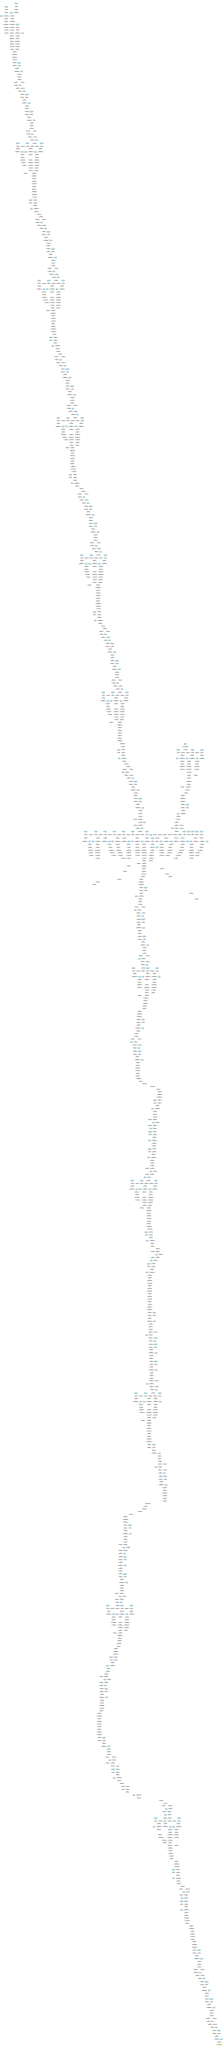

In [16]:
x = torch.randn((4,80,512))
y = model(x)
make_dot(y)

In [147]:
# x = get_spectrogram_feature(data[0]).unsqueeze(0).cuda()
x = torch.randn((4,80,512)).cuda()
target = [
    [1, 2, 3, 5, 0],
    [1, 2, 2, 0, 0],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 0, 0]
]
target = torch.tensor(target).cuda()

In [148]:
model(x, target).shape

torch.Size([4, 5, 820])

In [158]:
x.topk(1)[1].shape

torch.Size([4, 80, 1])

In [156]:
x.shape

torch.Size([4, 80, 512])

In [170]:
x = []
for i in range(28):
    x.append(torch.randn((4,256)))

In [171]:
y = torch.stack(x,dim=1)

In [172]:
y.shape

torch.Size([4, 28, 256])

In [173]:
type(x)

list